In this file:
- Get the price data for the NASDAQ100: Use the closing price, calculate daily returns by taking the log returns (np.log(price).diff())
    - *Q1: Should we take the percentage difference thing instead? like: $(p_t - p_t-1)/p_t-1$?*
    - *Q2: Should we take the daily difference as p_close - p_open or should it be p_close_today - p_close_yesterday? (currently have today - yesterday)?*

- Get data for the risk free asset: 
    - *Q1: Is the 10 year treasury note appropriate? if so is this data actually the right data?: https://www.investing.com/rates-bonds/us-10-yr-t-note-historical-data*
- Combine the two as 60/40 portfolio and calculate the returns of the portfolio:
    - *Is it correct to just do r_portfolio = 0.6 * r_ndq + 0.4 * r_rf?*
    - *When rebalancing the portfolio*: Right now we just calculate this each day (the returns), and count that as rebalancing the portfolio daily, is this correct? Do we need to set some 'budget' or number of shares to invest and allocate daily to have it be a portfolio? Kinda confused about how to construct the portfolio overall and how to rebalance daily.
- We want to calculate monthly sharpe ratio:
                $$\text{Sharpe ratio} = (r_{portfolio} - \text{risk free rate})/(\text{standard deviation of portfolio})$$
    - *Q1: Does it make sense to do it montlhy? should it be yearly or something instead?*
    - *Q2: Do calculate it we need the monthly returns. Whats the best way to calculate them? The two we tried are:*
        1. Just take the average of the daily returns to get the 'average monthly returns' needed for the sharpe ratio
        2. Caclulate the monthly returns using the following formula:
            - Return = $\Pi$ (Daily growth factor) - 1, where Daily growth factor = 1 + daily return
            - If we use this method, is the return in the daily growth factor still the % return right?
        - Which method is more appropriate? (or neither?)
    - *Q3: For the Sharpe ratio we need the risk free rate, for this we thought to use 1 month US t-bills, is that appropriate?*
        - Additionally: Is it then appropriate to use the GS1M as a proxy? (this data: https://fred.stlouisfed.org/series/GS1M), if not, what is?:
        - The yield is on an annual basis (right?), so we need to turn it to a monthly basis for the sharpe ratio calculations (right?). What method is appropriate for this? We tried two: 
            1. Approximation: (yield/12)/100 
            2. Formula: $$(1 + \text{yield}/100)^{1/12} - 1$$
            - When we do this the risk free rate is soooo low, does that make sense? over the period the t-bill anual yield is from 0.02%-2.45%, so maybe it does make sense that it's tiny?
            The yield over the period looks like: 
            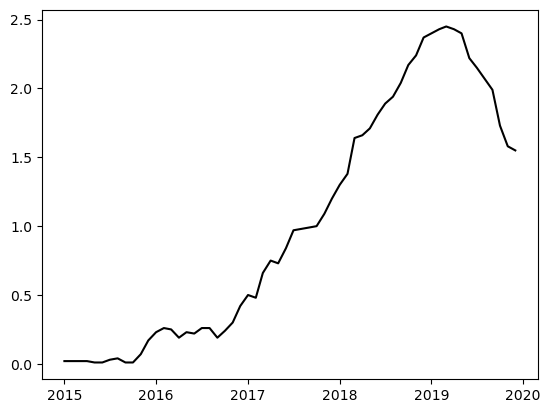 
    - *Q4: For the denumenator we need the standard deviation:*
        - Right now we calculate the monthly standard deviation of each assets based on the daily returns as: np.std(r_ndq) and np.std(r_rf), so we get one number for each month, does this make sense? does this still work if we use the monthly returns based on the growth factor formula instead of just the average monthly returns?
        - Are we supposed to assume that the standard deviation is 0 for the risk free asset? Since it's supposed to be 'risk free'? Because the standard deviation is not 0 when we calculate it...
        - When calculating the standard deviation of the portfolio we use the following formula:
            $$\sigma_{portfolio} = \sqrt{w_{ndq}^2*\sigma_{ndq}^2 + w_{rf}^2*\sigma_{rf}^2 + 2*w_{ndq}*w_{rf}*cov(r_{ndq}, r_{rf})}$$
            Is this correct?
    - *Q5: Finally, we calculate the sharpe ratio with this info and the resulting monthly sharpe ratio for the 5 year period looks like this: does it look correct? are the fluctuations weird?:*
        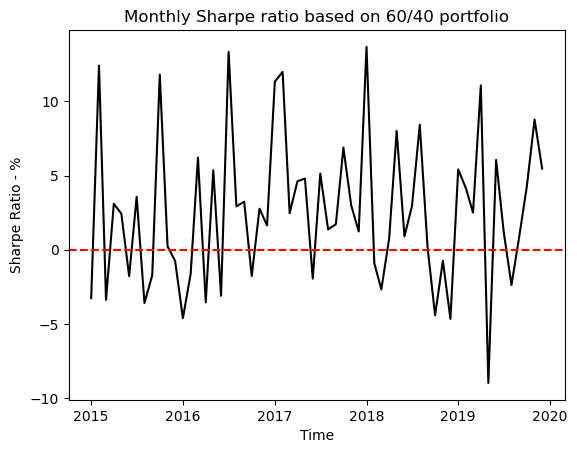
    
- If we want to get just 1 number for each portfolio by calculating the sharpe ratio for the entire period, could we do that by just taking the average of the monthly ones? Or do we need to calculate it all again? or do we calculate the standard deviation based on the monthly returns (np.std(monthly_returns_portfolio)) and then average returns and average risk free rate?

Heres a graph summarizing all the inputs for the sharpe and the sharpe itself, does anything look off? does it make sense?:
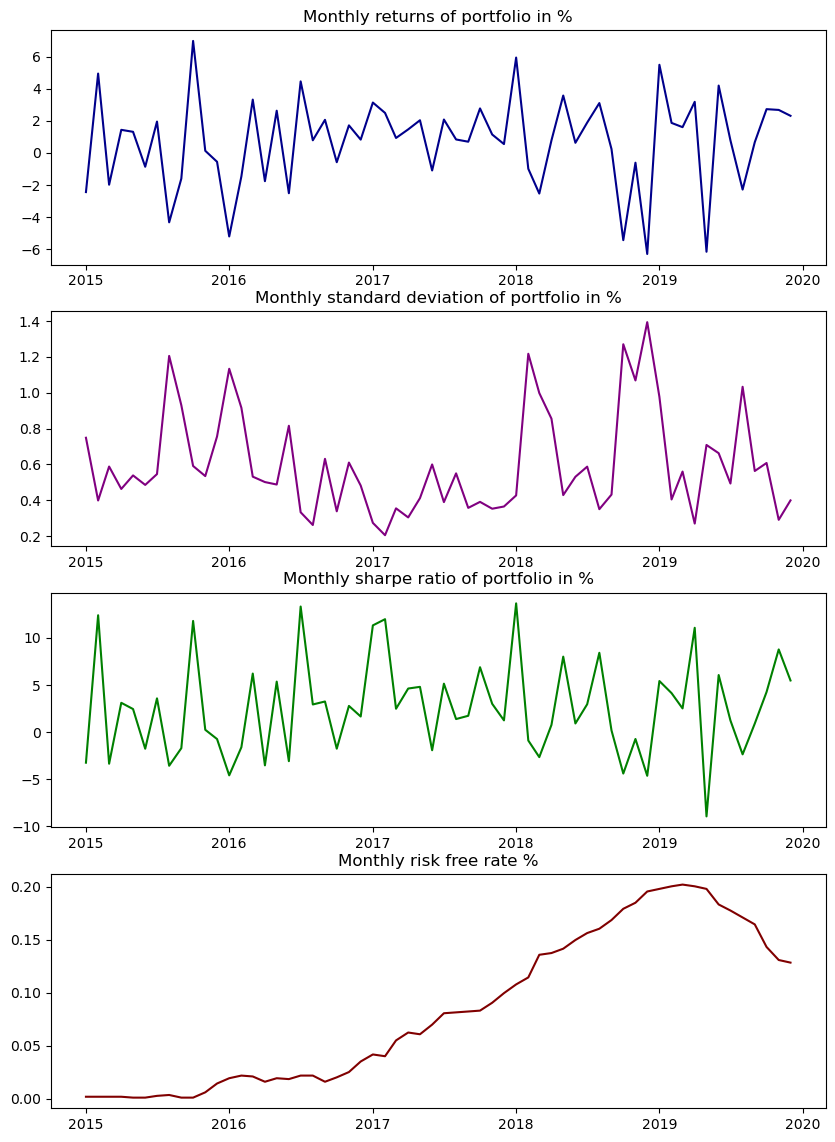


Other: What split should we use? 80/20 and then 20/80 for risk off? or 100/0 and 0/100? always 60/40 for neutral?
If we are changing the weights daily based on the volatility index / sentiment index, how would we calculate the monthly standard deviation of the portfolio? Since we dont have constant weights anymore so the formula doesnt work, or would it make sense to just take the average weight for each month as the weight in the formula? Or could we just take the standard deviation of the portfolio returns and not worry about the covariance stuff? (np.std(r_portfolio))

also: returns for just nasdaq higher than the benchmark, so if we have a classifier that tells us to always invest in nasdaq over the period we will get better returns than the benchmark.. will this be an issue? Give misleading results?

**Regarding sentiment index:**
we have tweets from the weekends, what would be the best way to deal with them? lump them with friday so their sentiment would effect the market on monday? ignore them? or what is the best way to deal with them?

------------------------------------------------------------------------------------------------
Want to calculate the risk adjusted returns for the NASDAQ100 stock over the period we are looking at.
Risk-adjusted returns are a way to assess an investment's performance relative to its risk. One of the most common measures for risk-adjusted returns is the Sharpe ratio.

Formula:
$$\text{Sharpe ratio} = \frac{\text{Risk premium}}{\text{SD of excess return}}$$
that is:
𝑆ℎ𝑎𝑟𝑝𝑒 𝑟𝑎𝑡𝑖𝑜=(𝐸(𝑟_𝐸𝐷 )−𝑟_𝑓)/𝜎_𝐸𝐷 

Sharpe Ratio = (Average Return of Investment - Risk-Free Rate) / Standard Deviation of Investment

First we need the average return, since we want to calculate this daily we can just use the daily return instead of average.
Calculate it using: Daily Return = (Price at Day N - Price at Day N-1) / Price at Day N-1
(so not log return?)

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [280]:
# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/Nasdaq100_price_data.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,4294.879883,4307.009766,4233.709961,4236.279785,4236.279785,1515600000
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000


In [281]:
price_df['r_ndq'] = np.log(price_df['Close']).diff() #not times 100 for dgf for now
price_df.dropna(inplace=True)
price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,r_ndq
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000,-0.001427
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000,-0.016513
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000,-0.012121
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000,0.011890
5,2015-01-08,4195.490234,4247.930176,4192.629883,4240.549805,4240.549805,2105450000,0.019178


Portfolio: use model to rebalance every day, and then calculate monthly sharpe ratio to compare the two portfolios (ours and the benchmark)

Steps we need:
- Add risk free returns to the data
- Calculate the returns for the benchmark portfolio
    - To do that: w_rf = 0.4, w_s = 0.6, r_bm = w_rf*r_rf + w_s *r_s
    - calculate them daily and then calculate monthly sharpe ratio:
        - to do that: Get monthly standard deviation -> based on date column 
        - get average monthly return for both the portfolio and just the risk free
        - calculate risk premium (r_bm - r_rf)
        - calculate sharpe ratio: risk premium / std_bm

**1. Get rf data:**

- 1. Load the data
- 2. Calculate daily returns
- 3. Add to dataframe (or make new dataframe with just the relevant info)


Here I download data from https://www.investing.com/rates-bonds/us-10-yr-t-note-historical-data
that is, it's data about the price of a future of the 10 year US treasury note I think.

In [282]:
rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US%2010%20Year%20T-Note%20Futures%20Historical%20Data.csv')

In [283]:
rf_df['r_rf'] = np.log(rf_df['Price']).diff()
rf_df.dropna(inplace=True)

In [284]:
rf_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,r_rf
1,12/30/2019,128.53,128.61,128.69,128.16,891.50K,-0.10%,0.000856
2,12/27/2019,128.66,128.41,128.67,128.39,667.29K,0.22%,0.001011
3,12/26/2019,128.38,128.36,128.47,128.20,402.21K,0.02%,-0.002179
5,12/24/2019,128.31,128.14,128.39,128.00,398.67K,0.17%,-0.000312
6,12/23/2019,128.09,128.22,128.39,128.05,620.13K,-0.12%,-0.001716


not sure what change % is...

In [285]:
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

**2. Calculate daily 60/40 portfolio returns**
- Use w_rf*r_rf + w_nq+r_nq

In [286]:
benchmark6040_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

benchmark6040_df.head()

,Date,r_ndq,r_rf
0,2015-01-02,-0.001427,-0.004786
1,2015-01-05,-0.016513,-0.004607
2,2015-01-06,-0.012121,-0.000857
3,2015-01-07,0.011890,0.002806
4,2015-01-08,0.019178,-0.003662


In [287]:
w_rf = 0.4
w_ndq = 0.6

In [288]:
benchmark6040_df['r_bm'] = w_rf*benchmark6040_df['r_rf'] + w_ndq*benchmark6040_df['r_ndq']

In [289]:
benchmark6040_df.head()

,Date,r_ndq,r_rf,r_bm
0,2015-01-02,-0.001427,-0.004786,-0.002770
1,2015-01-05,-0.016513,-0.004607,-0.011751
2,2015-01-06,-0.012121,-0.000857,-0.007615
3,2015-01-07,0.011890,0.002806,0.008257
4,2015-01-08,0.019178,-0.003662,0.010042


In [290]:
#add daily growth factor of portfolio:
benchmark6040_df['dgf_bm'] = benchmark6040_df['r_bm'] + 1
benchmark6040_df.head()

,Date,r_ndq,r_rf,r_bm,dgf_bm
0,2015-01-02,-0.001427,-0.004786,-0.002770,0.997230
1,2015-01-05,-0.016513,-0.004607,-0.011751,0.988249
2,2015-01-06,-0.012121,-0.000857,-0.007615,0.992385
3,2015-01-07,0.011890,0.002806,0.008257,1.008257
4,2015-01-08,0.019178,-0.003662,0.010042,1.010042


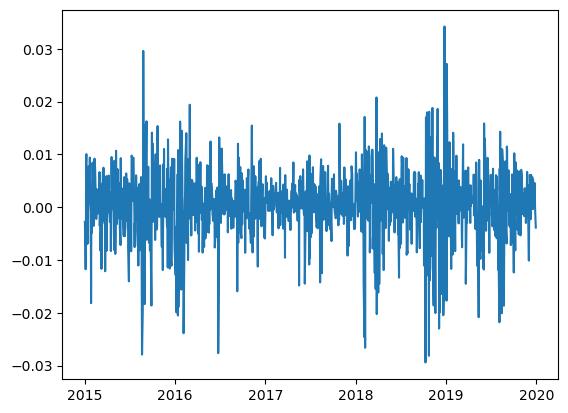

In [291]:
plt.plot(benchmark6040_df['Date'], benchmark6040_df['r_bm'])

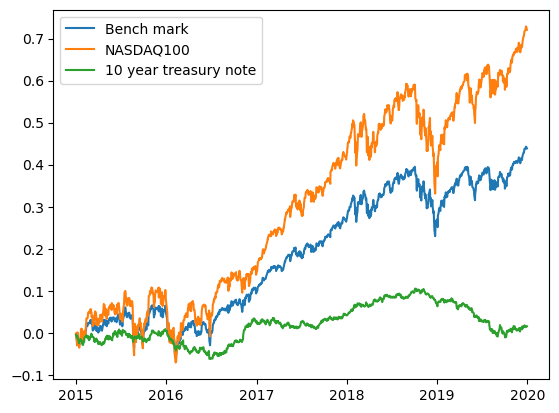

In [294]:
values_bm = benchmark6040_df['r_bm'].cumsum()
values_ndq = benchmark6040_df['r_ndq'].cumsum()
values_rf = benchmark6040_df['r_rf'].cumsum()

plt.plot(benchmark6040_df['Date'], values_bm, label='Bench mark')
plt.plot(benchmark6040_df['Date'], values_ndq, label='NASDAQ100')
plt.plot(benchmark6040_df['Date'], values_rf, label = '10 year treasury note')
plt.legend()

Final value of portfolio:  155.0540086415138


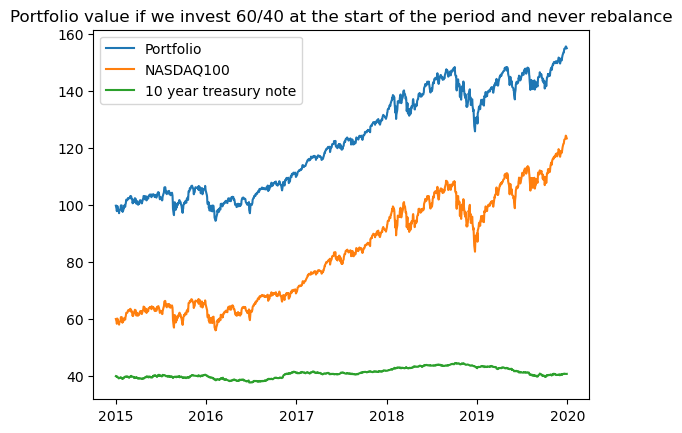

In [295]:
P = 60
history_ndq = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_ndq'][i])
    history_ndq.append(P)
    

P = 40
history_rf = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_rf'][i])
    history_rf.append(P)


P = 100
history_bm = [P]
for i in range(len(values_bm)):
    P = P*np.exp(benchmark6040_df['r_bm'][i])
    history_bm.append(P)

print('Final value of portfolio: ', P)

plt.plot(benchmark6040_df['Date'], history_bm[1:], label='Portfolio')
plt.plot(benchmark6040_df['Date'], history_ndq[1:], label='NASDAQ100')
plt.plot(benchmark6040_df['Date'], history_rf[1:], label = '10 year treasury note')
plt.title('Portfolio value if we invest 60/40 at the start of the period and never rebalance')
plt.legend()

**3. Calculate the monthly returns and standard devitations for the Sharpe ratio**

In [186]:
# Set 'Date' as the index of the DataFrame
benchmark6040_df.set_index('Date', inplace=True)

# Resample the data by month and calculate mean and standard deviation for specific columns
monthly_stats = benchmark6040_df.resample('M').agg({
    'r_ndq': ['mean', 'std'],
    'r_rf': ['mean', 'std'],
    'r_bm': 'mean',
    'dgf_bm': 'prod'
    })


# Flatten the MultiIndex in columns created by agg()
monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

grouped = benchmark6040_df.resample('M')
covariances = []
for month in grouped:
    cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
    row = {'Date': month[0], 'covariance': cov}
    covariances.append(row)

covariances = pd.DataFrame(covariances)
covariances.set_index('Date', inplace=True)

# Combine the results
monthly_stats = pd.concat([monthly_stats, covariances], axis=1)

print(monthly_stats)


            r_ndq_mean  r_ndq_std  r_rf_mean  r_rf_std  r_bm_mean  \
Date                                                                
2015-01-31   -0.001048   0.011984  -0.001449  0.003217  -0.001208   
2015-02-28    0.003583   0.005999   0.001001  0.003759   0.002550   
2015-03-31   -0.001108   0.009524  -0.000569  0.003394  -0.000893   
2015-04-30    0.000877   0.007947   0.000409  0.002601   0.000690   
2015-05-31    0.001054   0.008804   0.000086  0.003624   0.000667   
2015-06-30   -0.001138   0.008021   0.000751  0.004698  -0.000383   
2015-07-31    0.001944   0.009079  -0.000682  0.003052   0.000894   
2015-08-31   -0.003379   0.019993  -0.000019  0.003730  -0.002035   
2015-09-30   -0.001053   0.015852  -0.000237  0.003345  -0.000727   
2015-10-31    0.004820   0.009188   0.000486  0.003005   0.003087   
2015-11-30    0.000168   0.008544  -0.000055  0.002094   0.000079   
2015-12-31   -0.000700   0.012539   0.000487  0.003769  -0.000225   
2016-01-31   -0.003728   0.019087 

In [189]:
monthly_stats['monthly_returns_bm'] = monthly_stats['dgf_bm_prod'] - 1

In [190]:
monthly_stats.head()

,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,dgf_bm_prod,covariance,monthly_returns_bm
Date,,,,,,,,
2015-01-31,-0.001048,0.011984,-0.001449,0.003217,-0.001208,0.975586,5.572282e-06,-0.024414
2015-02-28,0.003583,0.005999,0.001001,0.003759,0.002550,1.049435,1.335955e-06,0.049435
2015-03-31,-0.001108,0.009524,-0.000569,0.003394,-0.000893,0.980186,1.097030e-07,-0.019814
2015-04-30,0.000877,0.007947,0.000409,0.002601,0.000690,1.014370,-5.021111e-06,0.014370
2015-05-31,0.001054,0.008804,0.000086,0.003624,0.000667,1.013138,-2.162920e-06,0.013138


In [191]:
#calculate standard deviation of the portfolio per month:

monthly_stats['std_bm'] = np.sqrt(w_ndq**2*monthly_stats['r_ndq_std']**2 + w_rf**2*monthly_stats['r_rf_std']**2 + 2*w_ndq*w_rf*monthly_stats['covariance'])

monthly_stats.head()

,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,dgf_bm_prod,covariance,monthly_returns_bm,std_bm
Date,,,,,,,,,
2015-01-31,-0.001048,0.011984,-0.001449,0.003217,-0.001208,0.975586,5.572282e-06,-0.024414,0.007485
2015-02-28,0.003583,0.005999,0.001001,0.003759,0.002550,1.049435,1.335955e-06,0.049435,0.003982
2015-03-31,-0.001108,0.009524,-0.000569,0.003394,-0.000893,0.980186,1.097030e-07,-0.019814,0.005878
2015-04-30,0.000877,0.007947,0.000409,0.002601,0.000690,1.014370,-5.021111e-06,0.014370,0.004627
2015-05-31,0.001054,0.008804,0.000086,0.003624,0.000667,1.013138,-2.162920e-06,0.013138,0.005382


In [192]:
monthly_stats = monthly_stats.reset_index()
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,dgf_bm_prod,covariance,monthly_returns_bm,std_bm
0,2015-01-31,-0.001048,0.011984,-0.001449,0.003217,-0.001208,0.975586,5.572282e-06,-0.024414,0.007485
1,2015-02-28,0.003583,0.005999,0.001001,0.003759,0.002550,1.049435,1.335955e-06,0.049435,0.003982
2,2015-03-31,-0.001108,0.009524,-0.000569,0.003394,-0.000893,0.980186,1.097030e-07,-0.019814,0.005878
3,2015-04-30,0.000877,0.007947,0.000409,0.002601,0.000690,1.014370,-5.021111e-06,0.014370,0.004627
4,2015-05-31,0.001054,0.008804,0.000086,0.003624,0.000667,1.013138,-2.162920e-06,0.013138,0.005382


In [193]:

# Change index to the first of each month
monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date']).dt.to_period('M').dt.to_timestamp().dt.date
monthly_stats.head()


,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,dgf_bm_prod,covariance,monthly_returns_bm,std_bm
0,2015-01-01,-0.001048,0.011984,-0.001449,0.003217,-0.001208,0.975586,5.572282e-06,-0.024414,0.007485
1,2015-02-01,0.003583,0.005999,0.001001,0.003759,0.002550,1.049435,1.335955e-06,0.049435,0.003982
2,2015-03-01,-0.001108,0.009524,-0.000569,0.003394,-0.000893,0.980186,1.097030e-07,-0.019814,0.005878
3,2015-04-01,0.000877,0.007947,0.000409,0.002601,0.000690,1.014370,-5.021111e-06,0.014370,0.004627
4,2015-05-01,0.001054,0.008804,0.000086,0.003624,0.000667,1.013138,-2.162920e-06,0.013138,0.005382


In [194]:
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,dgf_bm_prod,covariance,monthly_returns_bm,std_bm
0,2015-01-01,-0.001048,0.011984,-0.001449,0.003217,-0.001208,0.975586,5.572282e-06,-0.024414,0.007485
1,2015-02-01,0.003583,0.005999,0.001001,0.003759,0.002550,1.049435,1.335955e-06,0.049435,0.003982
2,2015-03-01,-0.001108,0.009524,-0.000569,0.003394,-0.000893,0.980186,1.097030e-07,-0.019814,0.005878
3,2015-04-01,0.000877,0.007947,0.000409,0.002601,0.000690,1.014370,-5.021111e-06,0.014370,0.004627
4,2015-05-01,0.001054,0.008804,0.000086,0.003624,0.000667,1.013138,-2.162920e-06,0.013138,0.005382


**4. Get the risk free rate (GS1M)**

In [213]:
r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/GS1M.csv')
r_rf_df.head()

,DATE,GS1M
0,2015-01-01,0.02
1,2015-02-01,0.02
2,2015-03-01,0.02
3,2015-04-01,0.02
4,2015-05-01,0.01


In [236]:
#divide by 12 to get monthly returns instead of annual:
#divide gs1m by 100 because it was already in % -> we dont want that here!
r_rf_df['monthly_rf'] = (1 + (r_rf_df['GS1M']/100))**(1/12) -1
r_rf_df.rename(columns = {'DATE':'Date'}, inplace = True)
r_rf_df.head()

,Date,GS1M,monthly_rf
0,2015-01-01,0.02,0.000017
1,2015-02-01,0.02,0.000017
2,2015-03-01,0.02,0.000017
3,2015-04-01,0.02,0.000017
4,2015-05-01,0.01,0.000008


In [206]:
monthly_stats['Date'].dtype

dtype('<M8[ns]')

**5. Finally: calculate the monthly sharpe ratio for the benchmark portfolio:**

In [198]:
monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date'])
monthly_stats.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,dgf_bm_prod,covariance,monthly_returns_bm,std_bm
0,2015-01-01,-0.001048,0.011984,-0.001449,0.003217,-0.001208,0.975586,5.572282e-06,-0.024414,0.007485
1,2015-02-01,0.003583,0.005999,0.001001,0.003759,0.002550,1.049435,1.335955e-06,0.049435,0.003982
2,2015-03-01,-0.001108,0.009524,-0.000569,0.003394,-0.000893,0.980186,1.097030e-07,-0.019814,0.005878
3,2015-04-01,0.000877,0.007947,0.000409,0.002601,0.000690,1.014370,-5.021111e-06,0.014370,0.004627
4,2015-05-01,0.001054,0.008804,0.000086,0.003624,0.000667,1.013138,-2.162920e-06,0.013138,0.005382


In [237]:
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])

In [238]:
sharpe_df = pd.merge(monthly_stats, r_rf_df, on='Date', how='left')

In [239]:
sharpe_df.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,dgf_bm_prod,covariance,monthly_returns_bm,std_bm,GS1M,monthly_rf
0,2015-01-01,-0.001048,0.011984,-0.001449,0.003217,-0.001208,0.975586,5.572282e-06,-0.024414,0.007485,0.02,0.000017
1,2015-02-01,0.003583,0.005999,0.001001,0.003759,0.002550,1.049435,1.335955e-06,0.049435,0.003982,0.02,0.000017
2,2015-03-01,-0.001108,0.009524,-0.000569,0.003394,-0.000893,0.980186,1.097030e-07,-0.019814,0.005878,0.02,0.000017
3,2015-04-01,0.000877,0.007947,0.000409,0.002601,0.000690,1.014370,-5.021111e-06,0.014370,0.004627,0.02,0.000017
4,2015-05-01,0.001054,0.008804,0.000086,0.003624,0.000667,1.013138,-2.162920e-06,0.013138,0.005382,0.01,0.000008


In [240]:
sharpe_df['risk_premium'] = sharpe_df['monthly_returns_bm'] - sharpe_df['monthly_rf']

#sharpe_bm = risk_premium / monthly_stats['std_bm']

In [241]:
sharpe_df['sharpe_ratio'] = sharpe_df['risk_premium']/(sharpe_df['std_bm']*100)
#*100 because we didnt make it into percentages yet!
sharpe_df.head()

,Date,r_ndq_mean,r_ndq_std,r_rf_mean,r_rf_std,r_bm_mean,dgf_bm_prod,covariance,monthly_returns_bm,std_bm,GS1M,monthly_rf,risk_premium,sharpe_ratio
0,2015-01-01,-0.001048,0.011984,-0.001449,0.003217,-0.001208,0.975586,5.572282e-06,-0.024414,0.007485,0.02,0.000017,-0.024430,-0.032638
1,2015-02-01,0.003583,0.005999,0.001001,0.003759,0.002550,1.049435,1.335955e-06,0.049435,0.003982,0.02,0.000017,0.049418,0.124098
2,2015-03-01,-0.001108,0.009524,-0.000569,0.003394,-0.000893,0.980186,1.097030e-07,-0.019814,0.005878,0.02,0.000017,-0.019831,-0.033737
3,2015-04-01,0.000877,0.007947,0.000409,0.002601,0.000690,1.014370,-5.021111e-06,0.014370,0.004627,0.02,0.000017,0.014353,0.031022
4,2015-05-01,0.001054,0.008804,0.000086,0.003624,0.000667,1.013138,-2.162920e-06,0.013138,0.005382,0.01,0.000008,0.013130,0.024395


Text(0.5, 1.0, 'Monthly Sharpe ratio based on 60/40 portfolio')

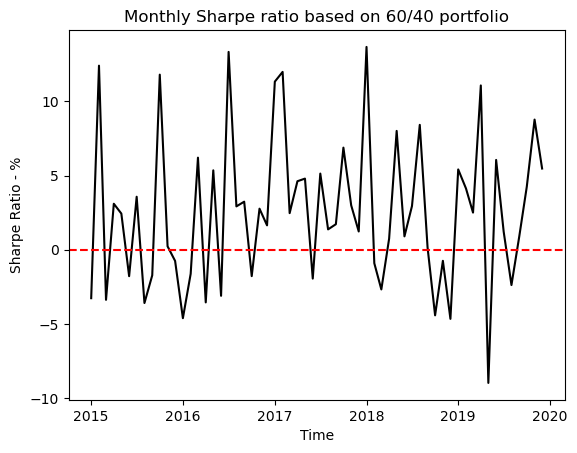

In [253]:
plt.plot(sharpe_df['Date'], sharpe_df['sharpe_ratio']*100, color = 'black')
plt.xlabel('Time')
plt.ylabel('Sharpe Ratio - %')
plt.axhline(0, color = 'red', linestyle = '--')
plt.title('Monthly Sharpe ratio based on 60/40 portfolio')

In [298]:
np.average(sharpe_df['sharpe_ratio'])

0.025408479238552707

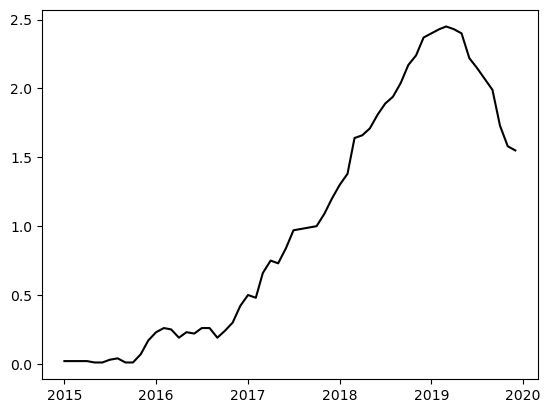

In [248]:
plt.plot(sharpe_df['Date'], sharpe_df['GS1M'], color = 'black')
#plt.plot(sharpe_df['Date'], sharpe_df['monthly_returns_bm']*100)

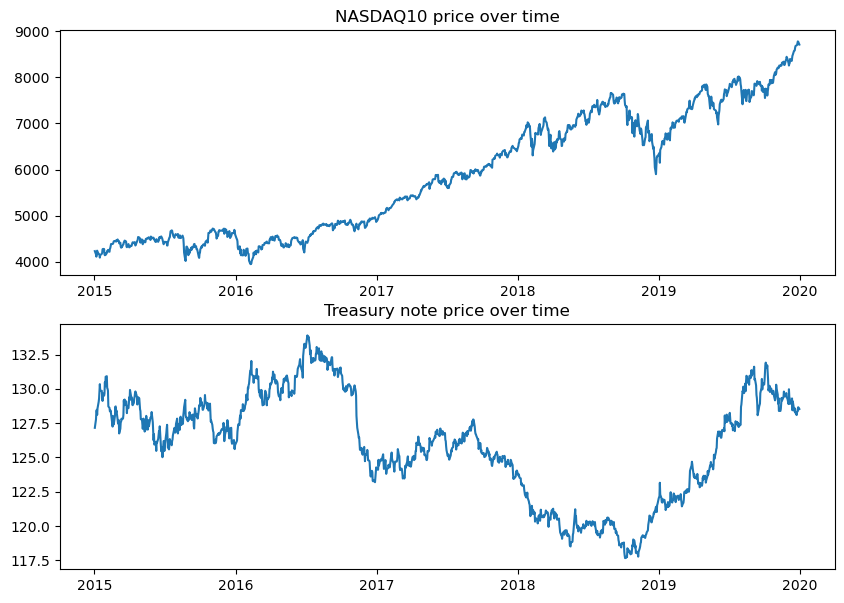

In [264]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.title('NASDAQ10 price over time')
plt.plot(price_df['Date'], price_df['Close'])
plt.subplot(2,1,2)
plt.title('Treasury note price over time')
plt.plot(rf_df['Date'], rf_df['Price'])

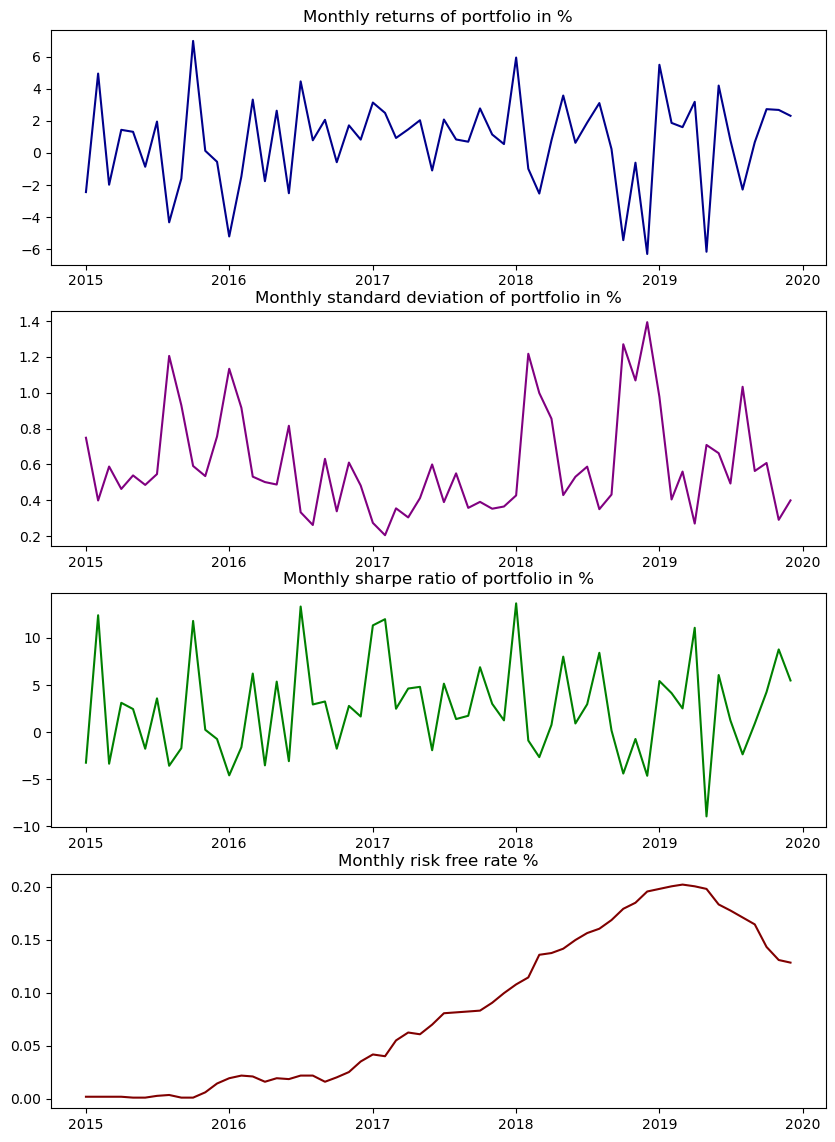

In [277]:
plt.figure(figsize=(10,14))
plt.subplot(4,1,1)
plt.title('Monthly returns of portfolio in %')
plt.plot(sharpe_df['Date'], sharpe_df['monthly_returns_bm']*100, color = 'darkblue')
#plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(4,1,2)
plt.title('Monthly standard deviation of portfolio in %')
plt.plot(sharpe_df['Date'], sharpe_df['std_bm']*100, color = 'purple')
#plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(4,1,3)
plt.title('Monthly sharpe ratio of portfolio in %')
plt.plot(sharpe_df['Date'], sharpe_df['sharpe_ratio']*100, color = 'green')
#plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(4,1,4)
plt.title('Monthly risk free rate %')
plt.plot(sharpe_df['Date'], sharpe_df['monthly_rf']*100, color = 'maroon')
#plt.axhline(0, color = 'red', linestyle = '--')



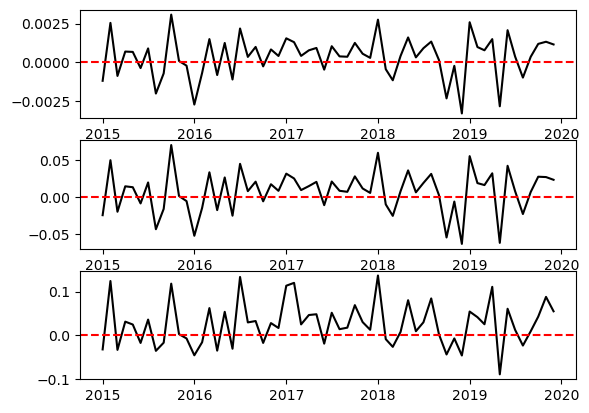

In [249]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(sharpe_df['Date'], sharpe_df['r_bm_mean'], color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(3,1,2)
plt.plot(sharpe_df['Date'], sharpe_df['monthly_returns_bm'], color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(3,1,3)
plt.plot(sharpe_df['Date'], sharpe_df['sharpe_ratio'], color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

plt.subplot(3,1,3)
plt.plot(sharpe_df['Date'], sharpe_df['sharpe_ratio'], color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

In [230]:
np.average(sharpe_df['sharpe_ratio'])

-7.782598020267792

In [231]:
std_ndq_m = np.std(sharpe_df['r_ndq_mean'])
std_rf_m = np.std(sharpe_df['r_rf_mean'])
cov_m = np.cov(sharpe_df['r_ndq_mean'], sharpe_df['r_rf_mean'])[0,1]

std_bm_m = np.sqrt(w_ndq**2 * std_ndq_m + w_rf**2 * std_rf_m + 2*w_ndq*w_rf*cov_m) 

average_return = np.average(sharpe_df['r_bm_mean'])
rf_return = np.average(sharpe_df['monthly_rf'])

sharpe_total = (average_return-rf_return)/std_bm_m

sharpe_total

-1.8022490148797325

In [296]:
benchmark6040_df['r_bm'].sum()

0.43860331308752154

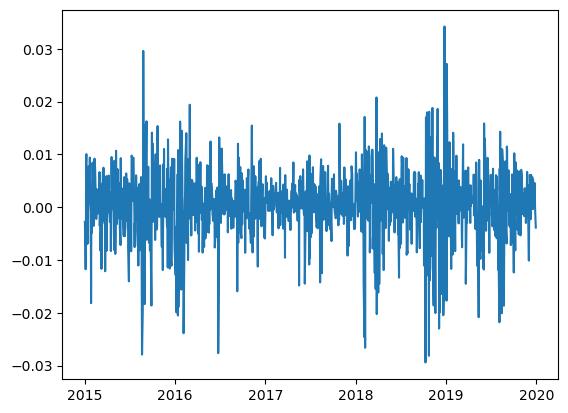

In [297]:
plt.plot(benchmark6040_df['Date'], benchmark6040_df['r_bm'])

overall sharpe:

In [299]:
risk_prem = monthly_stats['monthly_returns_bm'].mean() - r_rf_df['monthly_rf'].mean()
std_bm = np.std(monthly_stats['monthly_returns_bm'])
overall_sharpe = risk_prem/std_bm *100
overall_sharpe

22.901641735848465